# Group 18 Proposal - Credit card score and Education Levels



Dataset Link : http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

### Introduction:
When signing up for a credit card one receives a limit based on the card signed up for and credit score. Many struggle to manage their spendings, especially when financially independent. This is due to bills that need to be tracked if one is to pay off accrued credit card debt. Typically, those with a higher education level tend to earn higher income (CBC News, 2016) and are thus able to pay off credit card debt as well as have a higher credit limit. Those with a education level of highschool graduate or lower tend to earn less and have less opportunity for financial growth (Indeed Editorial Team, 2021) and therefore may struggle to pay back their debt and have a lower credit limit. Can we predict a person's education based on how much of their credit limit they spend and how much they pay back? We will use the "default of credit card clients Data Set" from UCI to answer this. Attributes included in the dataset are the amount of credit given, which includes an individual's credit limit, supplementary family credit, gender, education, marital status, age, payment history, amount of bill statement, and amount of previous payment.

### Methods and Results

#### Reading The Data From the Web:

We imported and loaded several libraries for different purposes. The `readxl` library has functions that allow us to load Excel data conveniently into R. The functions in the `tidyverse` library allow us to manipulate, clean, and wrangle data frames and tibbles. The `repr` library allows us to create and edit (resize) visualizations (plots) with readable text. We employ functions in the library `tidymodels` for data preprocessing, modelling, and statistical analysis including standardizing and centering data, performing the K-nearest neighbours classification, and finding the accuracy of the model. In addition, to make this random sample reproducible, we will `set.seed(1234)`.

In [2]:
# RUN THIS FIRST
install.packages('patchwork')
install.packages('expss')
library(readxl)
library(tidyverse)
library(repr)
library(tidymodels)
library(patchwork)
library(expss)
set.seed(1234) # DO NOT CHANGE FOR RESULTS TO BE REPLICABLE

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘checkmate’, ‘foreign’, ‘htmlTable’, ‘matrixStats’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ─

#### Reading The Data From the Web

We obtained data from the UCI Machine Learning Repository on the credit card history of clients (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). We use `read_excel` to read in the Excel file to R and create the data frame credit. We use the function `head()` to view the first few rows of the data set.

In [3]:
# Data from Citation #1
temp <- tempfile()
download.file("http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",temp)
credit <- read_excel(temp,skip = 1)
unlink(temp)

In [4]:
head(credit,n=3) %>%
    set_caption('Table 1.0 Raw Credit Data from UCI')

Table 1.0 Raw Credit Data from UCI# A tibble: 3 x 25
     ID LIMIT_BAL   SEX EDUCATION MARRIAGE   AGE PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6 `default payment next month`
  <dbl>     <dbl> <dbl>     <dbl>    <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>     <dbl>     <dbl>     <dbl>     <dbl>     <dbl>     <dbl>    <dbl>    <dbl>    <dbl>    <dbl>    <dbl>    <dbl>                        <dbl>
1     1     20000     2         2        1    24     2     2    -1    -1    -2    -2      3913      3102       689         0         0         0        0      689        0        0        0        0                            1
2     2    120000     2         2        2    26    -1     2     0     0     0     2      2682      1725      2682      3272      3455      3261        0     1000     1000     1000        0     2000                            1
3     3     90000     2         2        2    34     0     0     0     0     0     0     29239     14027     13559     14331     14948     15549     1518     1500     1000     1000     1000     5000                            0

#### Cleaning and Wrangling Data
We are predicting the education level of an individual based on their credit history, looking at the average amount of credit used by the individual (NT dollars) relative to their credit limit and the average amount paid (NT dollars). Prior to data We use the select() function to select relevant columns including `ID`, `LIMIT_BAL`, `EDUCATION`, `BILL_AMT1:BILL_AMT6`, and `PAY_AMT1:PAY_AMT6`. Note: the numeric label part of the naming of the variable in `BILL_AMT1:BILL_AMT6` or `PAY_AMT1:PAY_AMT6` refers to months.

The first step to cleaning the data is the `EDUCATION` variable. The observations can be observed to go up to 6, however, they were only categorizing up to 4 in proper documentation. Seeing as how 4 corresponds to "other" we have decided to only take education values from 1-3 using the filter() function. Note: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). Next, in the `BILL_AMT` observations, some of the vectors contained negative numbers. Negative balances are a rare occurence and only happen in strange circumstances so we will not be including them in our data set.

To obtain the appropriate predictors, we will create the predictor `PAY_AVG`, representing payment average, by using the `mutate()` function and calculating the average between variables `PAY_AMT1:PAY_AMT6`. Similarly, we will create the predictor `BILL_AVG` through the `mutate()` function where we first take the average of variables `BILL_AMT1:BILL_AMT6` and dividing it with `LIMIT_BAL` to essentially find on average what fraction of their credit limit has a person racked up in bills through the six months. For both `BILL_AVG` and `PAY_AVG` observations, we will be filtering those out as they can be considered outliers. Lastly, since we are viewing `EDUCATION` as a categorical variable, we will use `as.factor()` to convert it into a factor. Overall, the number of instances were reduced to 27,603 from 30,001 after cleaning and wrangling. We use the `head()` function to show the first few rows of `credit_rel` or `Table 1.1 Wrangled and Cleaned Credit Data`. 

In [5]:
credit_rel <- credit %>%
    select(ID, LIMIT_BAL, EDUCATION, PAY_AMT1:PAY_AMT6, BILL_AMT1:BILL_AMT6) %>%
    filter(EDUCATION < 4, EDUCATION != 0) %>%
    filter_all(all_vars(. >= 0)) %>%
    mutate(PAY_AVG = (PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6,
          BILL_AVG = (BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6)/6,
          BILL_AVG = BILL_AVG/LIMIT_BAL) %>%
          select(EDUCATION, PAY_AVG, BILL_AVG) %>%
          filter(PAY_AVG <= 100000, BILL_AVG <= 2)
credit_rel$EDUCATION <- as.factor(credit_rel$EDUCATION)
head(credit_rel,n=6) %>%
    set_caption('Table 1.1 Wrangled and Cleaned Credit Data')


Table 1.1 Wrangled and Cleaned Credit Data# A tibble: 6 x 3
  EDUCATION PAY_AVG BILL_AVG
  <fct>       <dbl>    <dbl>
1 2            115.   0.0642
2 2            833.   0.0237
3 2           1836.   0.188 
4 2           1398    0.771 
5 2           9842.   0.364 
6 1           1295.   0.794

#### Splitting the Data

Now, we will split the `credit_rel` data frame into training and testing datasets. This allows us to assess the accuracy of a model on data that the model has not trained on before. This is important because if we run all the data into the model, we will not be able to test the accuracy of the model on "new" data, which may result in the model overestimating or underestimating the data. We use the function `initial_split()` to split `credit_rel`, specifying the `prop` argument to be 60% and `EDUCATION` for the `strata` argument. Since we have a sufficiently large dataset, we decided to partition it to 60% training and 40% testing as we believe there is enough data to fit the most appropriate model and evaluate it on “unseen” or “new” data. This process results in data frames `credit_train` and `credit_test`. 


In [6]:
credit_split <- initial_split(credit_rel, prop = 0.6, strata = EDUCATION)
credit_train <- training(credit_split)
credit_test <- testing(credit_split)


#### Tabular Exploratory Data Analysis:
Upon initial tabular exploration (see `Table 2.0`), we see that majority of people in this dataset have finished university, followed by graduate school, then high school graduates. It can be observed that on average, higher education correlating to higher `PAY_AVG` and lower `BILL_AVG` values, meaning they pay more expensive bills and spent a lower fraction of their credit limit respectively. The analysis was completed through the use of functions `group_by()` to group observations by the `EDUCATION` variable, and `summarize()` to count the number of observations in each group and calculate the mean of `PAY_AVG` and `BILL_AVG` in each category. 

In [7]:
credit_edu <- credit_train %>%
    group_by(EDUCATION) %>%
    summarize(COUNT = n(), PAY_AVG = mean(PAY_AVG), BILL_AVG = mean(BILL_AVG))
credit_edu %>%
    set_caption('Table 2.0 Credit Data Aggregated by Education Type')

`summarise()` ungrouping output (override with `.groups` argument)



Table 2.0 Credit Data Aggregated by Education Type# A tibble: 3 x 4
  EDUCATION COUNT PAY_AVG BILL_AVG
  <fct>     <int>   <dbl>    <dbl>
1 1          5801   6175.    0.294
2 2          7974   4607.    0.441
3 3          2788   4053.    0.456

#### Visual Exploratory Data Analysis:
Prior to fitting the model, we use histograms and scatterplots to perform a visual exploration on the training data. We use `ggplot()` and `geom_histogram()` to plot histograms of each predictor, `BILL_AVG` and `PAY_AVG`, to observe the proportion of credit limit billed and the credit paid per month. Similarly, we use `geom_point()` to form a scatterplot with `BILL_AVG` on the x-axis, `PAY_AVG` on the y-axis, and coloring for `EDUCATION`. This allows us to see a possible relationship between the average credit paid per month and proportion of credit limit billed for different education levels. We observe `Figure 2.0` tells us that a vast majority of people do not surpass their monthly credit limit, and most people spent between 0-10% of their credit limit. On the other hand, `Figure 2.1` indicates that very few people pay over 4000 dollars back to their credit card company and vast majority pay less than 100 dollars. In `Figure 2.2` below, is a scatterplot of the 2 predictors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



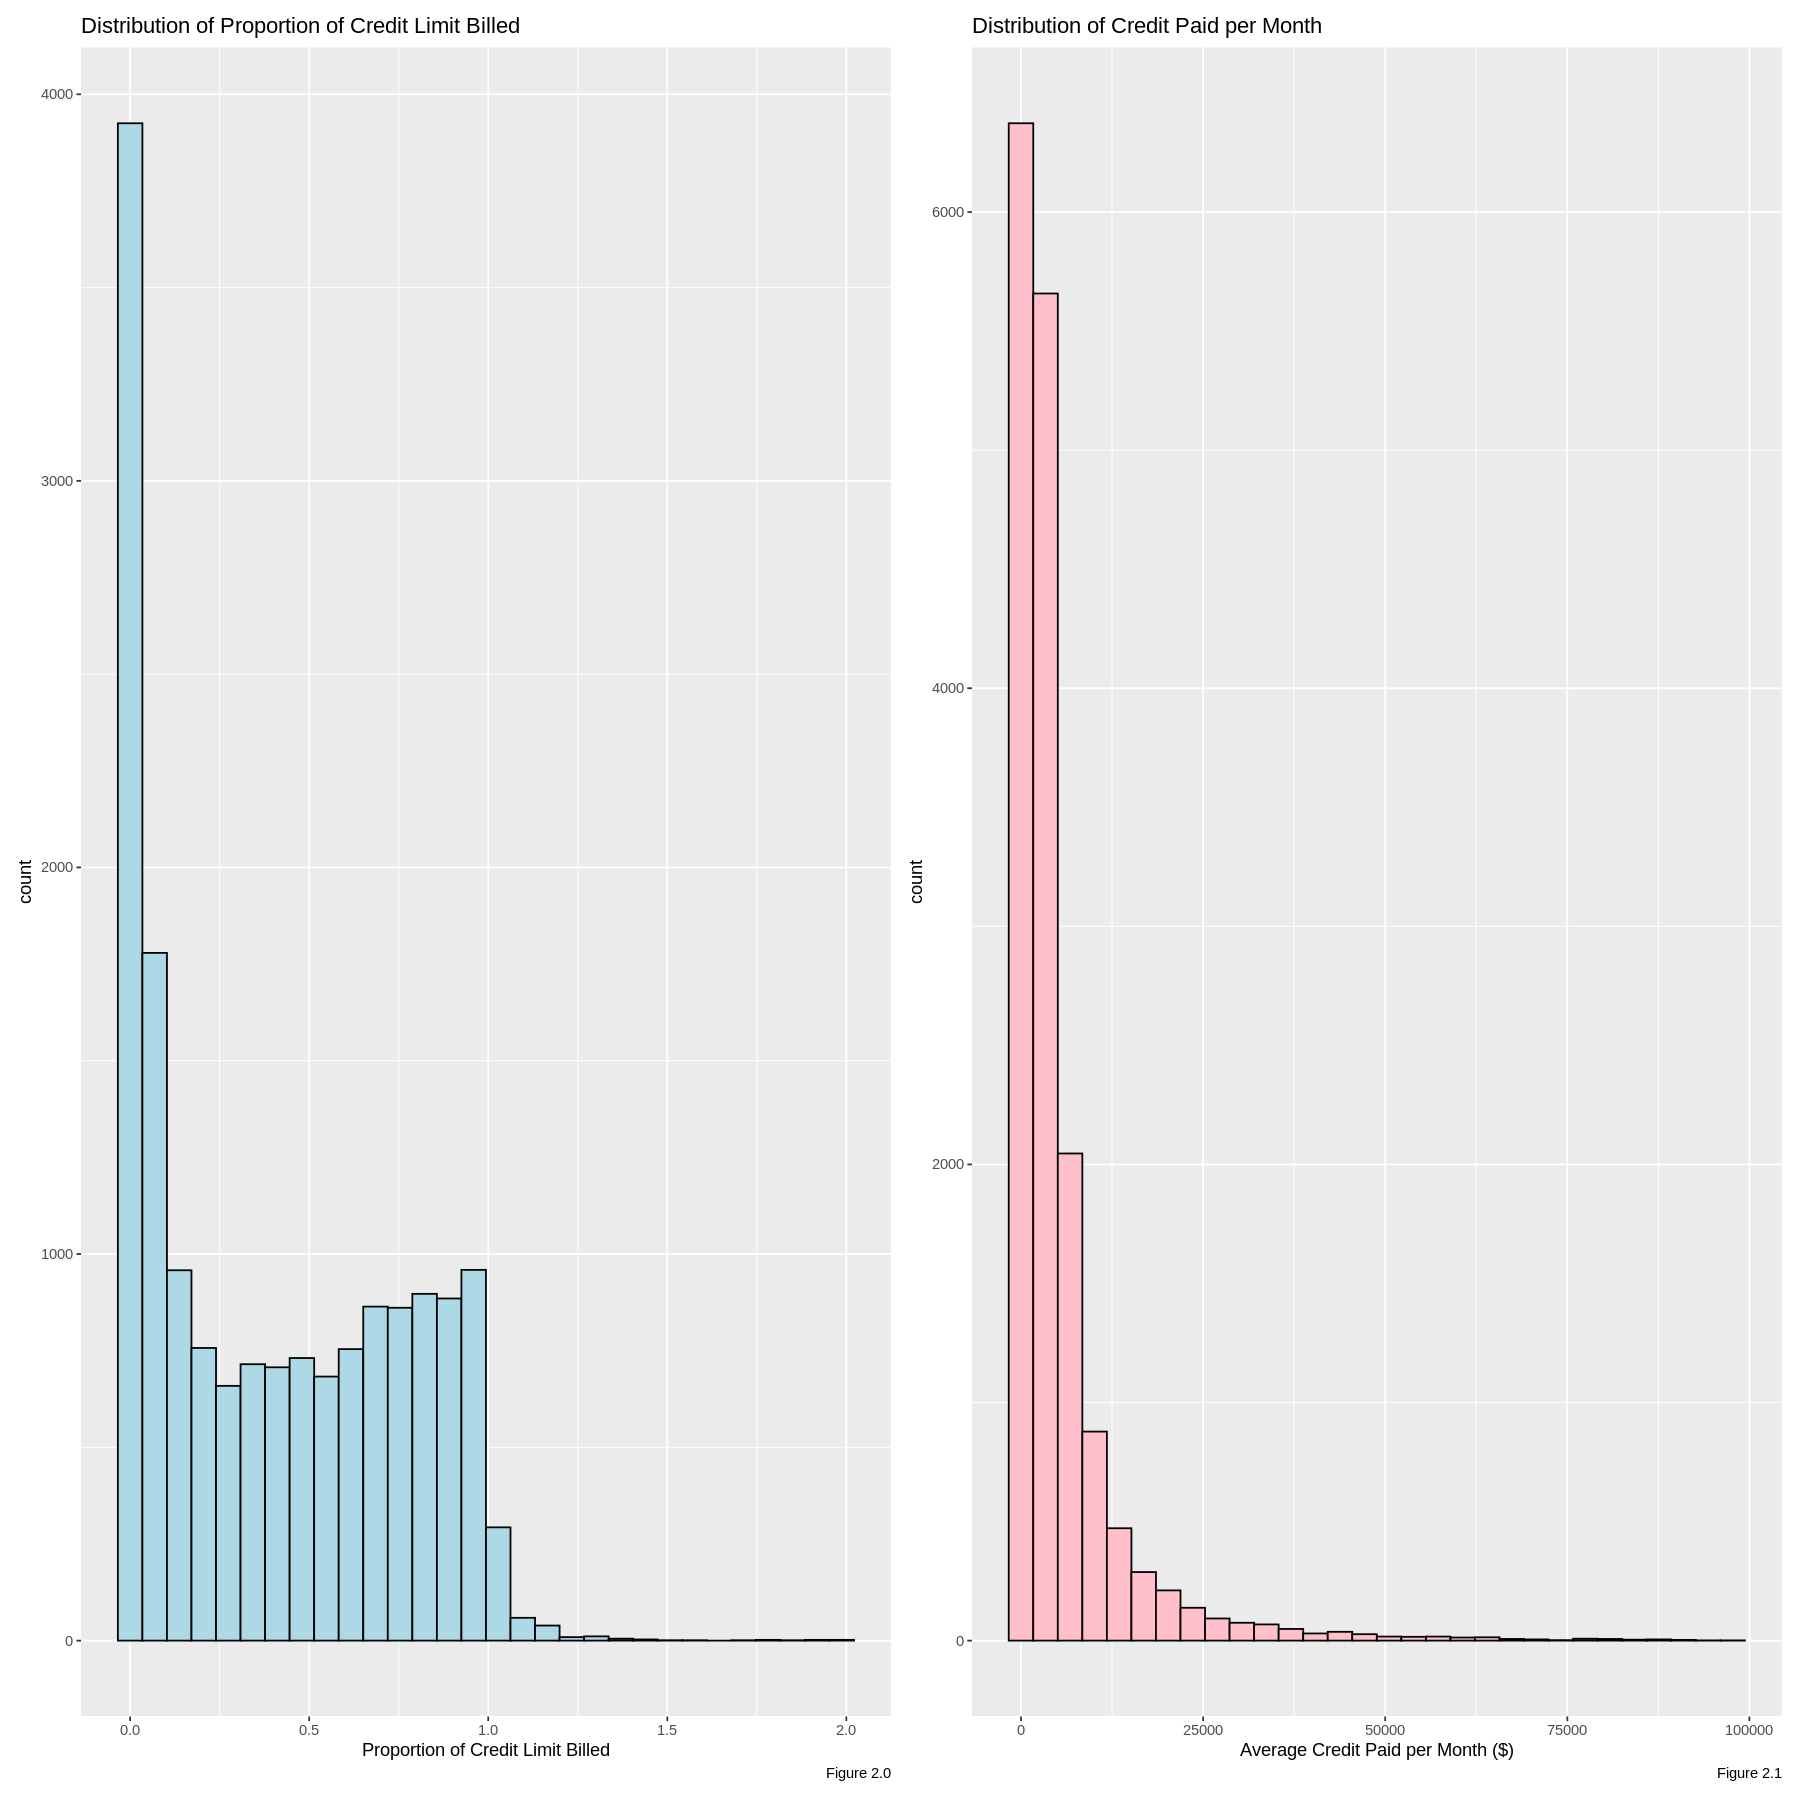

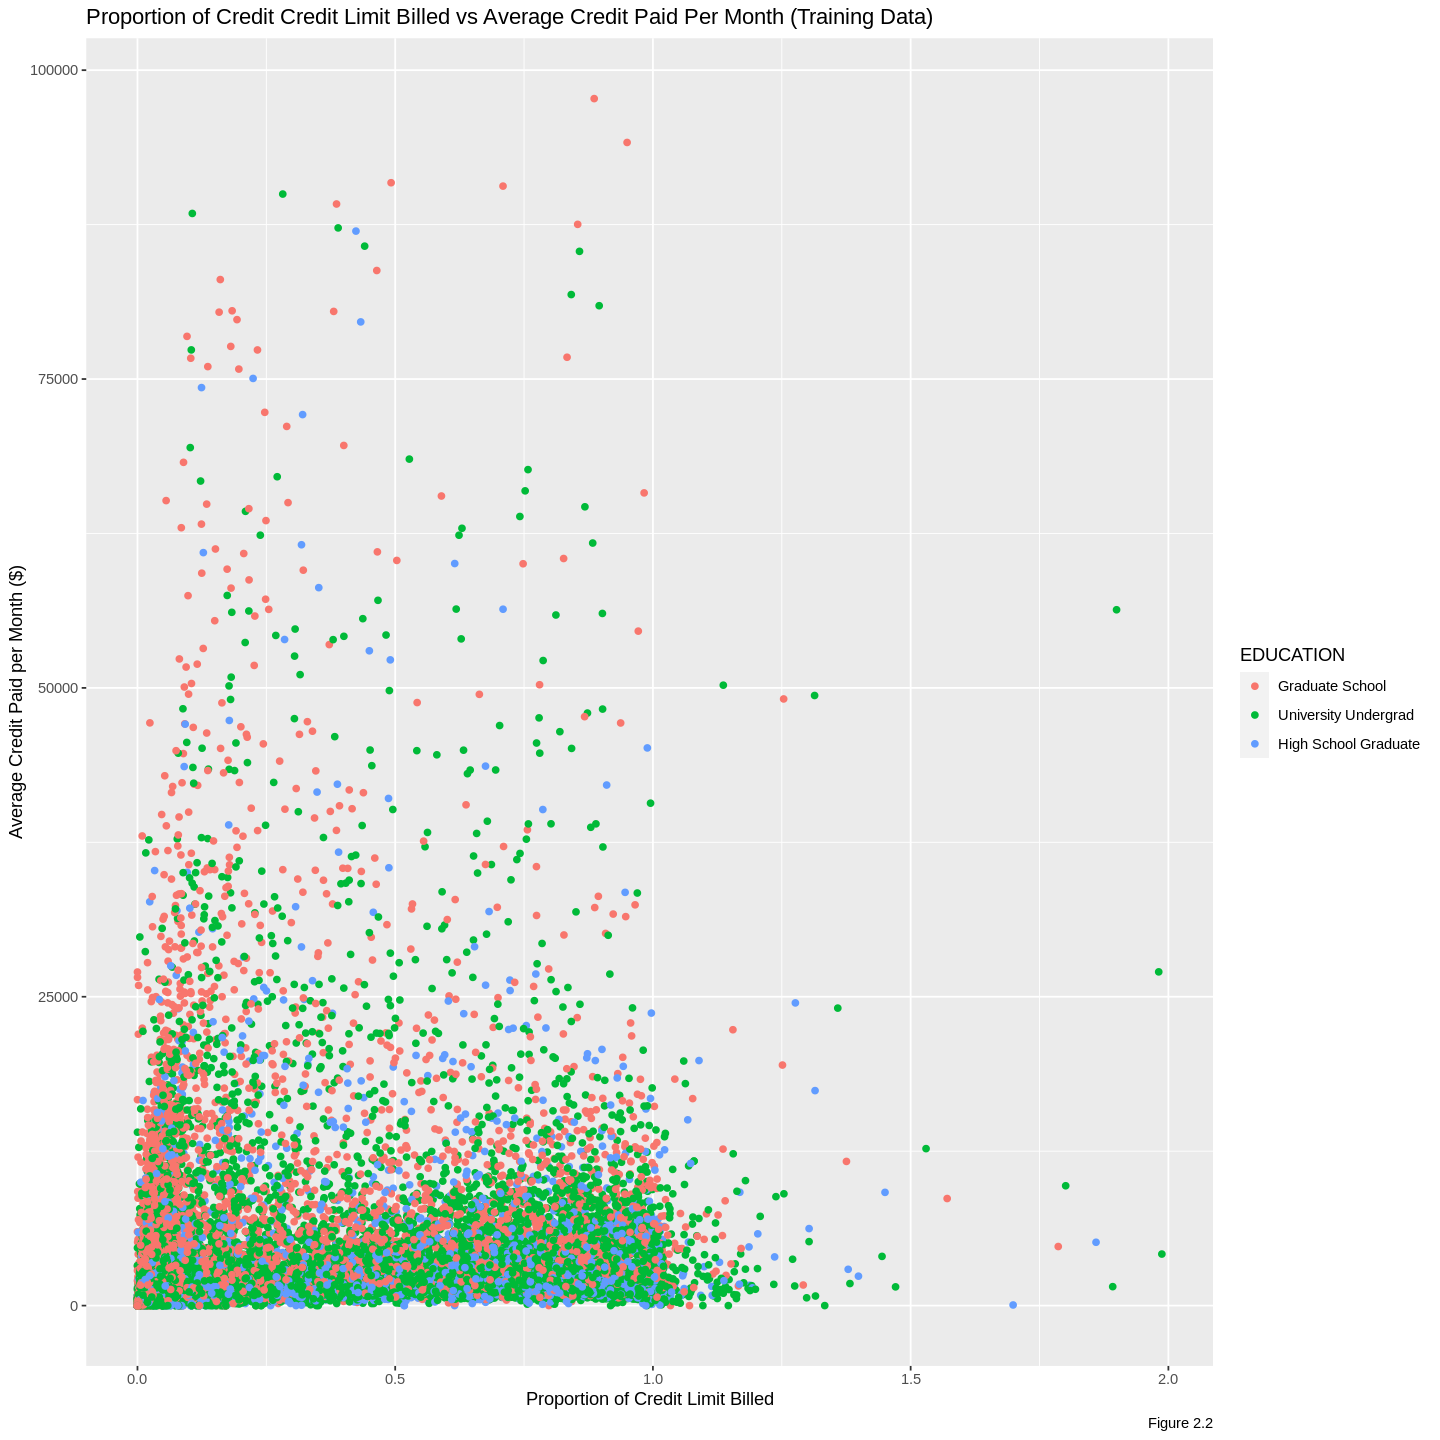

In [8]:
options(repr.plot.width = 15, repr.plot.height = 15)

bill_plot <- credit_train %>%
    ggplot(aes(x=BILL_AVG)) +
    geom_histogram(color='black',fill='light blue') +
    labs(x='Proportion of Credit Limit Billed', caption = 'Figure 2.0') +
    ggtitle('Distribution of Proportion of Credit Limit Billed')
pay_plot <- credit_train %>%
    ggplot(aes(x=PAY_AVG)) +
    geom_histogram(color='black',fill='pink') +
    labs(x='Average Credit Paid per Month ($)',caption = 'Figure 2.1') +
    ggtitle('Distribution of Credit Paid per Month')

bill_plot + pay_plot

options(repr.plot.width = 12, repr.plot.height = 12)
point_plot <- credit_train %>%
    ggplot(aes(x=BILL_AVG,y=PAY_AVG,colour = EDUCATION)) +
    geom_point() +
    labs(x='Proportion of Credit Limit Billed',y='Average Credit Paid per Month ($)', caption = 'Figure 2.2') +
    ggtitle('Proportion of Credit Credit Limit Billed vs Average Credit Paid Per Month (Training Data)') +
    scale_colour_discrete(labels = c("Graduate School","University Undergrad","High School Graduate"))

point_plot

#### Tuning The Model
Before performing the K-nearest neighbor classification, we create a recipe that uses the two predictors and standardize them. Standardizing involves upsampling, centering, and scaling the training data. To account for an imbalance in the training data where the model will not predict the data to be of a rare class, we use `step_upsample()` to rebalance the data by replicating rare observations in the data set for it to have a greater weight in the K-nearest algorithm. The `prep()` function completes the computation for upsampling to be executed, and the `bake()` function preprocessed recipe, in this case the `even_recipe`, and applies it to the training data to get `even_credit`. We also create a new recipe named `credit_recipe` to call `step_scale()` and `step_center()` to normalize the distance calculated in classification and ensure the data is tidy. We do not need to call `prep()` because it will be placed in a workflow. We created two separate recipes as we want to pass a model specification with a balanced data set to the `fit()` function to create the most appropriate final model.

We proceed to create a model specification with tuning on the number of neighbors, and perform a 3-fold cross-validation. A workflow analysis that adds the recipe and model specification, defines the tuning to 200 K values, and collects the metrics. 

In [37]:
even_recipe <- recipe(EDUCATION ~.,data = credit_train) %>%
  step_upsample(EDUCATION, over_ratio = 1, skip = FALSE) %>%
   prep()
even_credit <- bake(even_recipe,credit_train)

credit_recipe <- recipe(EDUCATION ~.,data = credit_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

In [38]:
### THIS BLOCK MAY TAKE 15-20 MINUTES TO RUN
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

credit_vfold <- vfold_cv(credit_train, v=3, strata = EDUCATION)

k_vals <- tibble(neighbors = seq(from =1, to =150, by= 3))

knn_accuracy <- workflow() %>%
    add_recipe(credit_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = credit_vfold, grid = k_vals) %>%
    collect_metrics() %>%
    filter(.metric == 'accuracy')


#### Visualizing the data
We evaluate the best value for the number of neighbors (k-value) by creating a line plot through the functions including `geom_point()` and `geom_line()`. In `Figure 3.0`, we can observe a maxima at around 100-150. `Figure 3.1` represents `Figure 3.0` narrowed down to `K = 100-150`. In that plot we observe that the K with the highest accuracy is 76 and 126. In our final model we will use `K = 76` as the difference in accuracy is negligible and a lower K results is less expensive computations further down the line. It may be important to underline that the cross-validation gives us as an unbiased estimate of the k value. Here is the visual result of this step if you choose to not run the below code:

![Drag Racing](img/Figure3.0.png)


Warning message:
“Removed 20 rows containing missing values (geom_point).”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


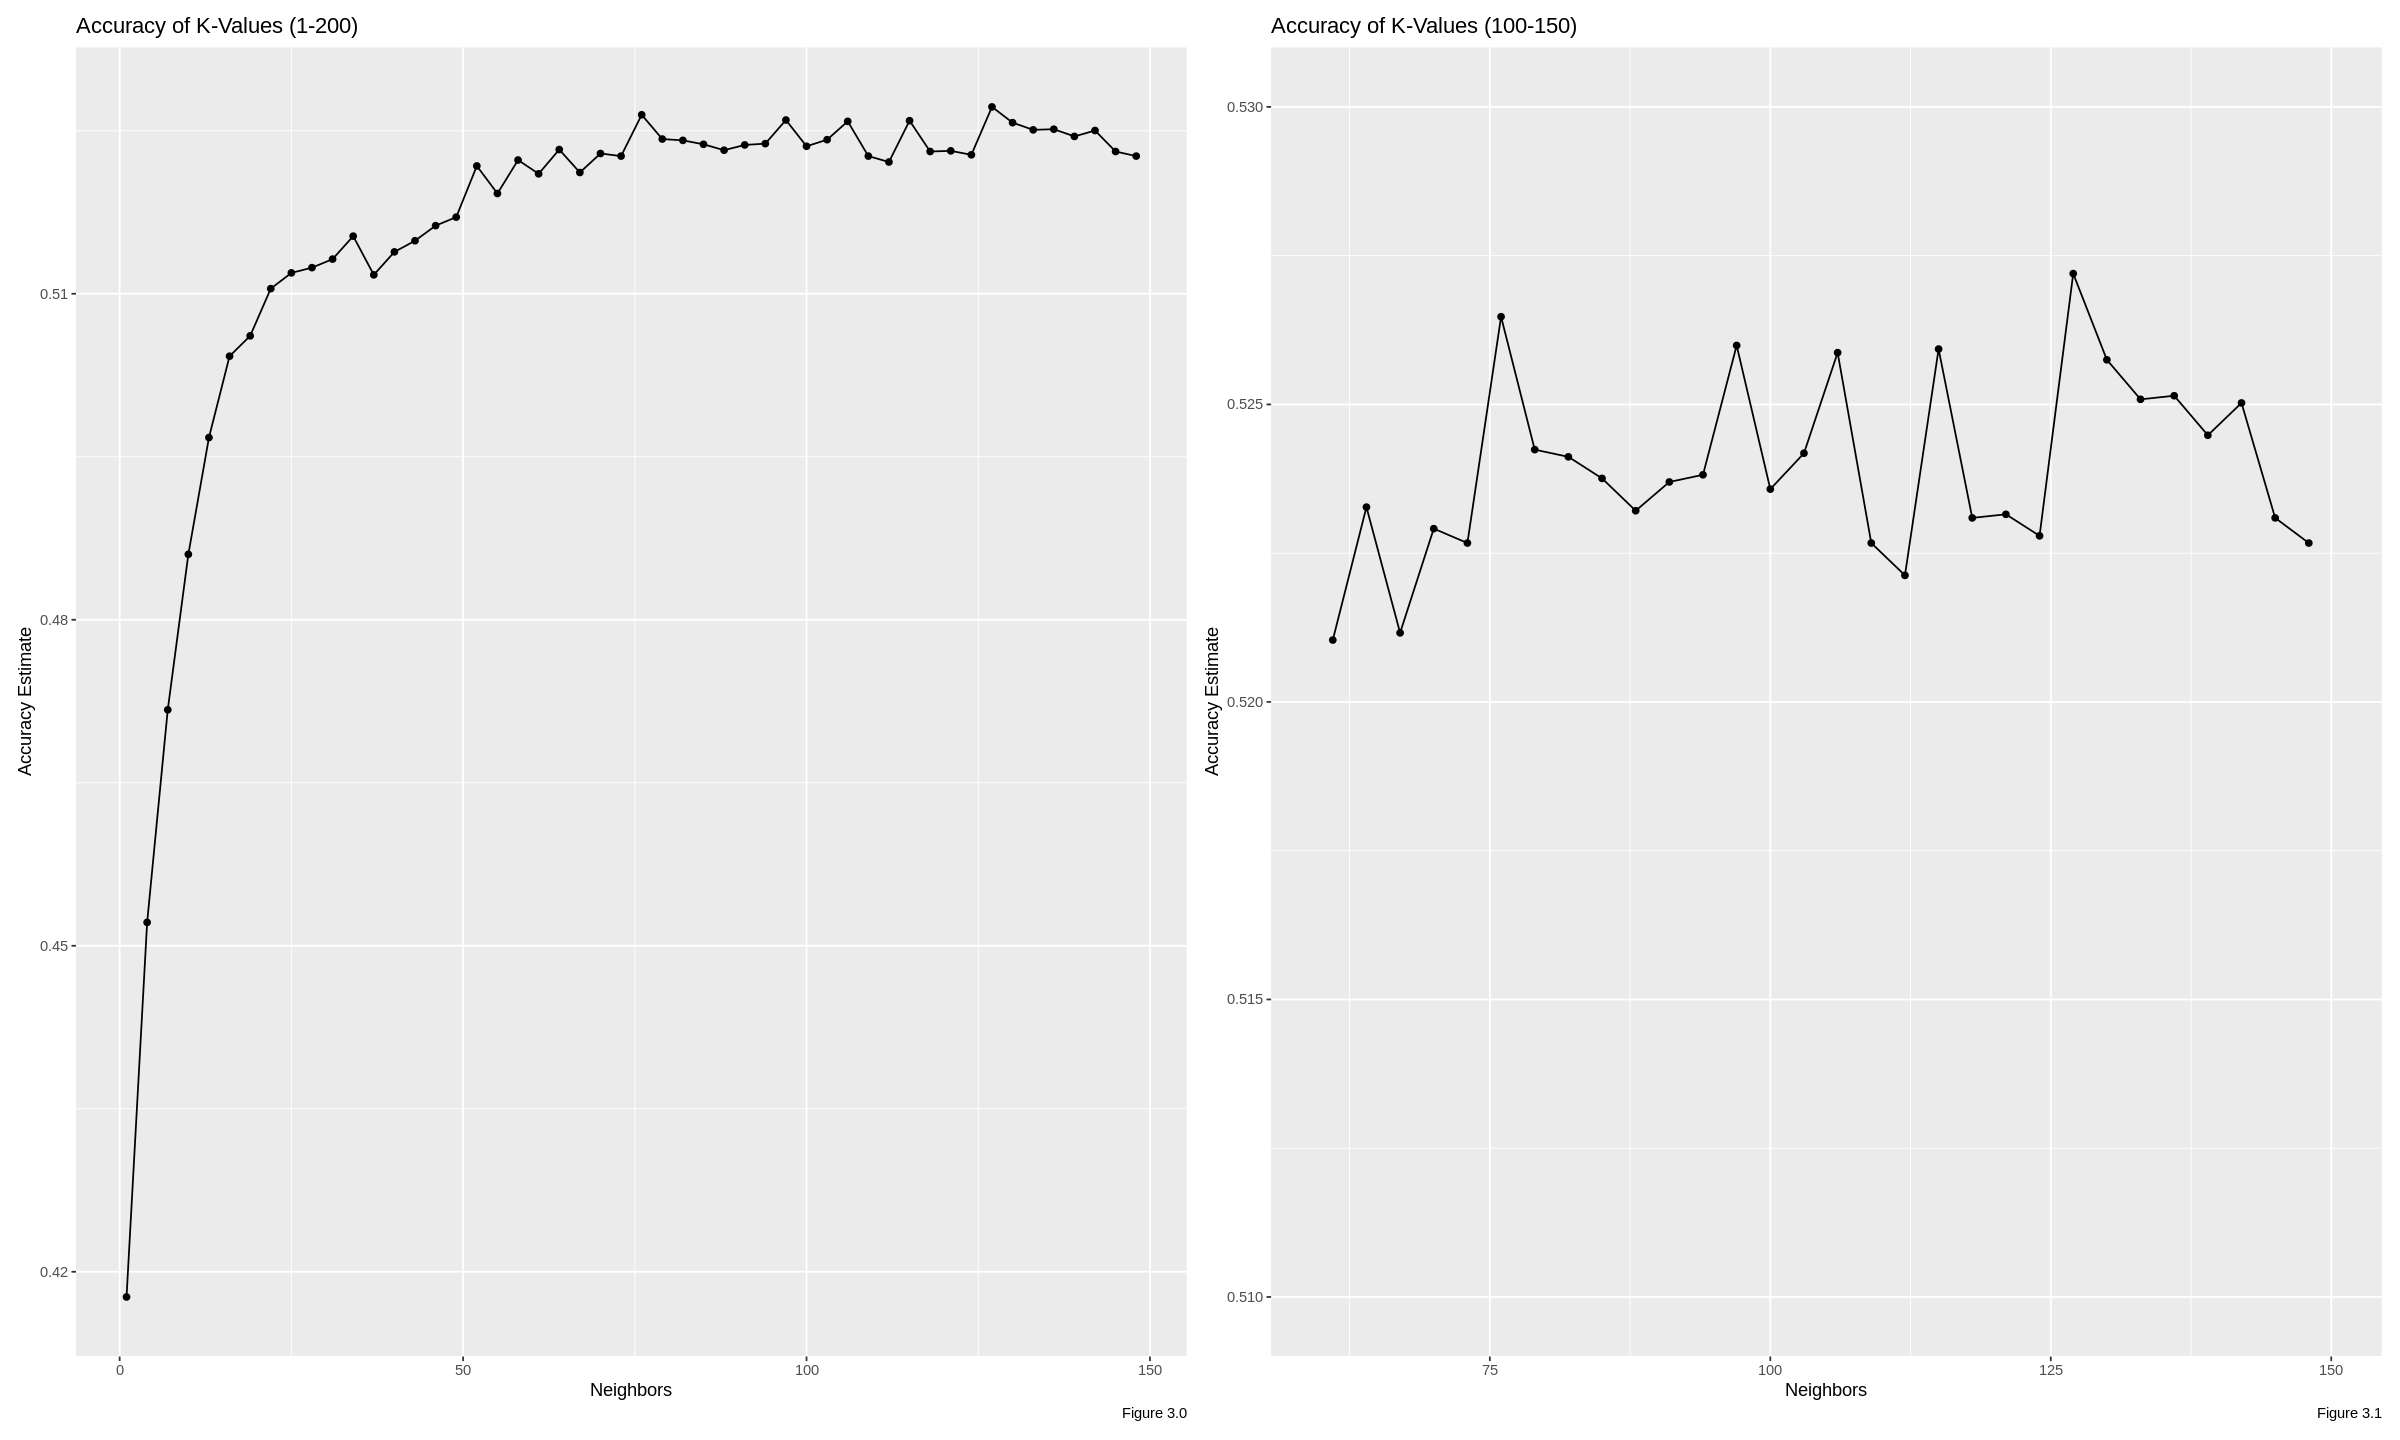

In [50]:
options(repr.plot.width = 20, repr.plot.height = 12)
accuracy_versus_k <- ggplot(knn_accuracy, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate",caption='Figure 3.0') +
      ggtitle('Accuracy of K-Values (1-200)')


accuracy_versus_k0 <- ggplot(knn_accuracy, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate",caption='Figure 3.1') +
      scale_x_continuous(limits = c(60,150)) +
      scale_y_continuous(limits = c(0.51,0.53)) +
      ggtitle('Accuracy of K-Values (100-150)')

accuracy_versus_k + accuracy_versus_k0

#### Training The Model with K=114 and Predicting The Test Data
We can now train the data again by specifying `K = 76` and create a new workflow on the tuned model. We fit the knn model, `knn_76`, with the recipe `credit_recipe` to the previously baked training data `even_credit`. Finally, we input the final model to the function `predict()` to predict on the testing dataset, `credit_test`. We report the accuracy of this prediction and the confusion matrix using the function `conf_mat()`. To compare and contrast the testing data and the predictions on the testing data by the final model, we plotted the scatterplots illustrating both cases through functions `geom_point()` and colouring by `EDUCATION`.

In [45]:
knn_76 <- knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = 76) %>%
    set_engine('kknn') %>%
    set_mode('classification')
                                        
credit_fit <- workflow() %>%
            add_recipe(credit_recipe) %>%
            add_model(knn_76) %>%
            fit(data = even_credit)

credit_test_predictions <- predict(credit_fit, credit_test) %>%
    bind_cols(credit_test)

credit_accuracy <- credit_test_predictions %>%
    metrics(truth = EDUCATION, estimate = .pred_class)

credit_accuracy %>%
    set_caption('Table 3.0 Accuracy')

Table 3.0 Accuracy# A tibble: 2 x 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy multiclass     0.401
2 kap      multiclass     0.109

In [46]:
credit_mat <- credit_test_predictions %>%
    conf_mat(truth = EDUCATION, estimate = .pred_class)
credit_mat

          Truth
Prediction    1    2    3
         1 2146 1850  594
         2  814 1575  557
         3  906 1891  707

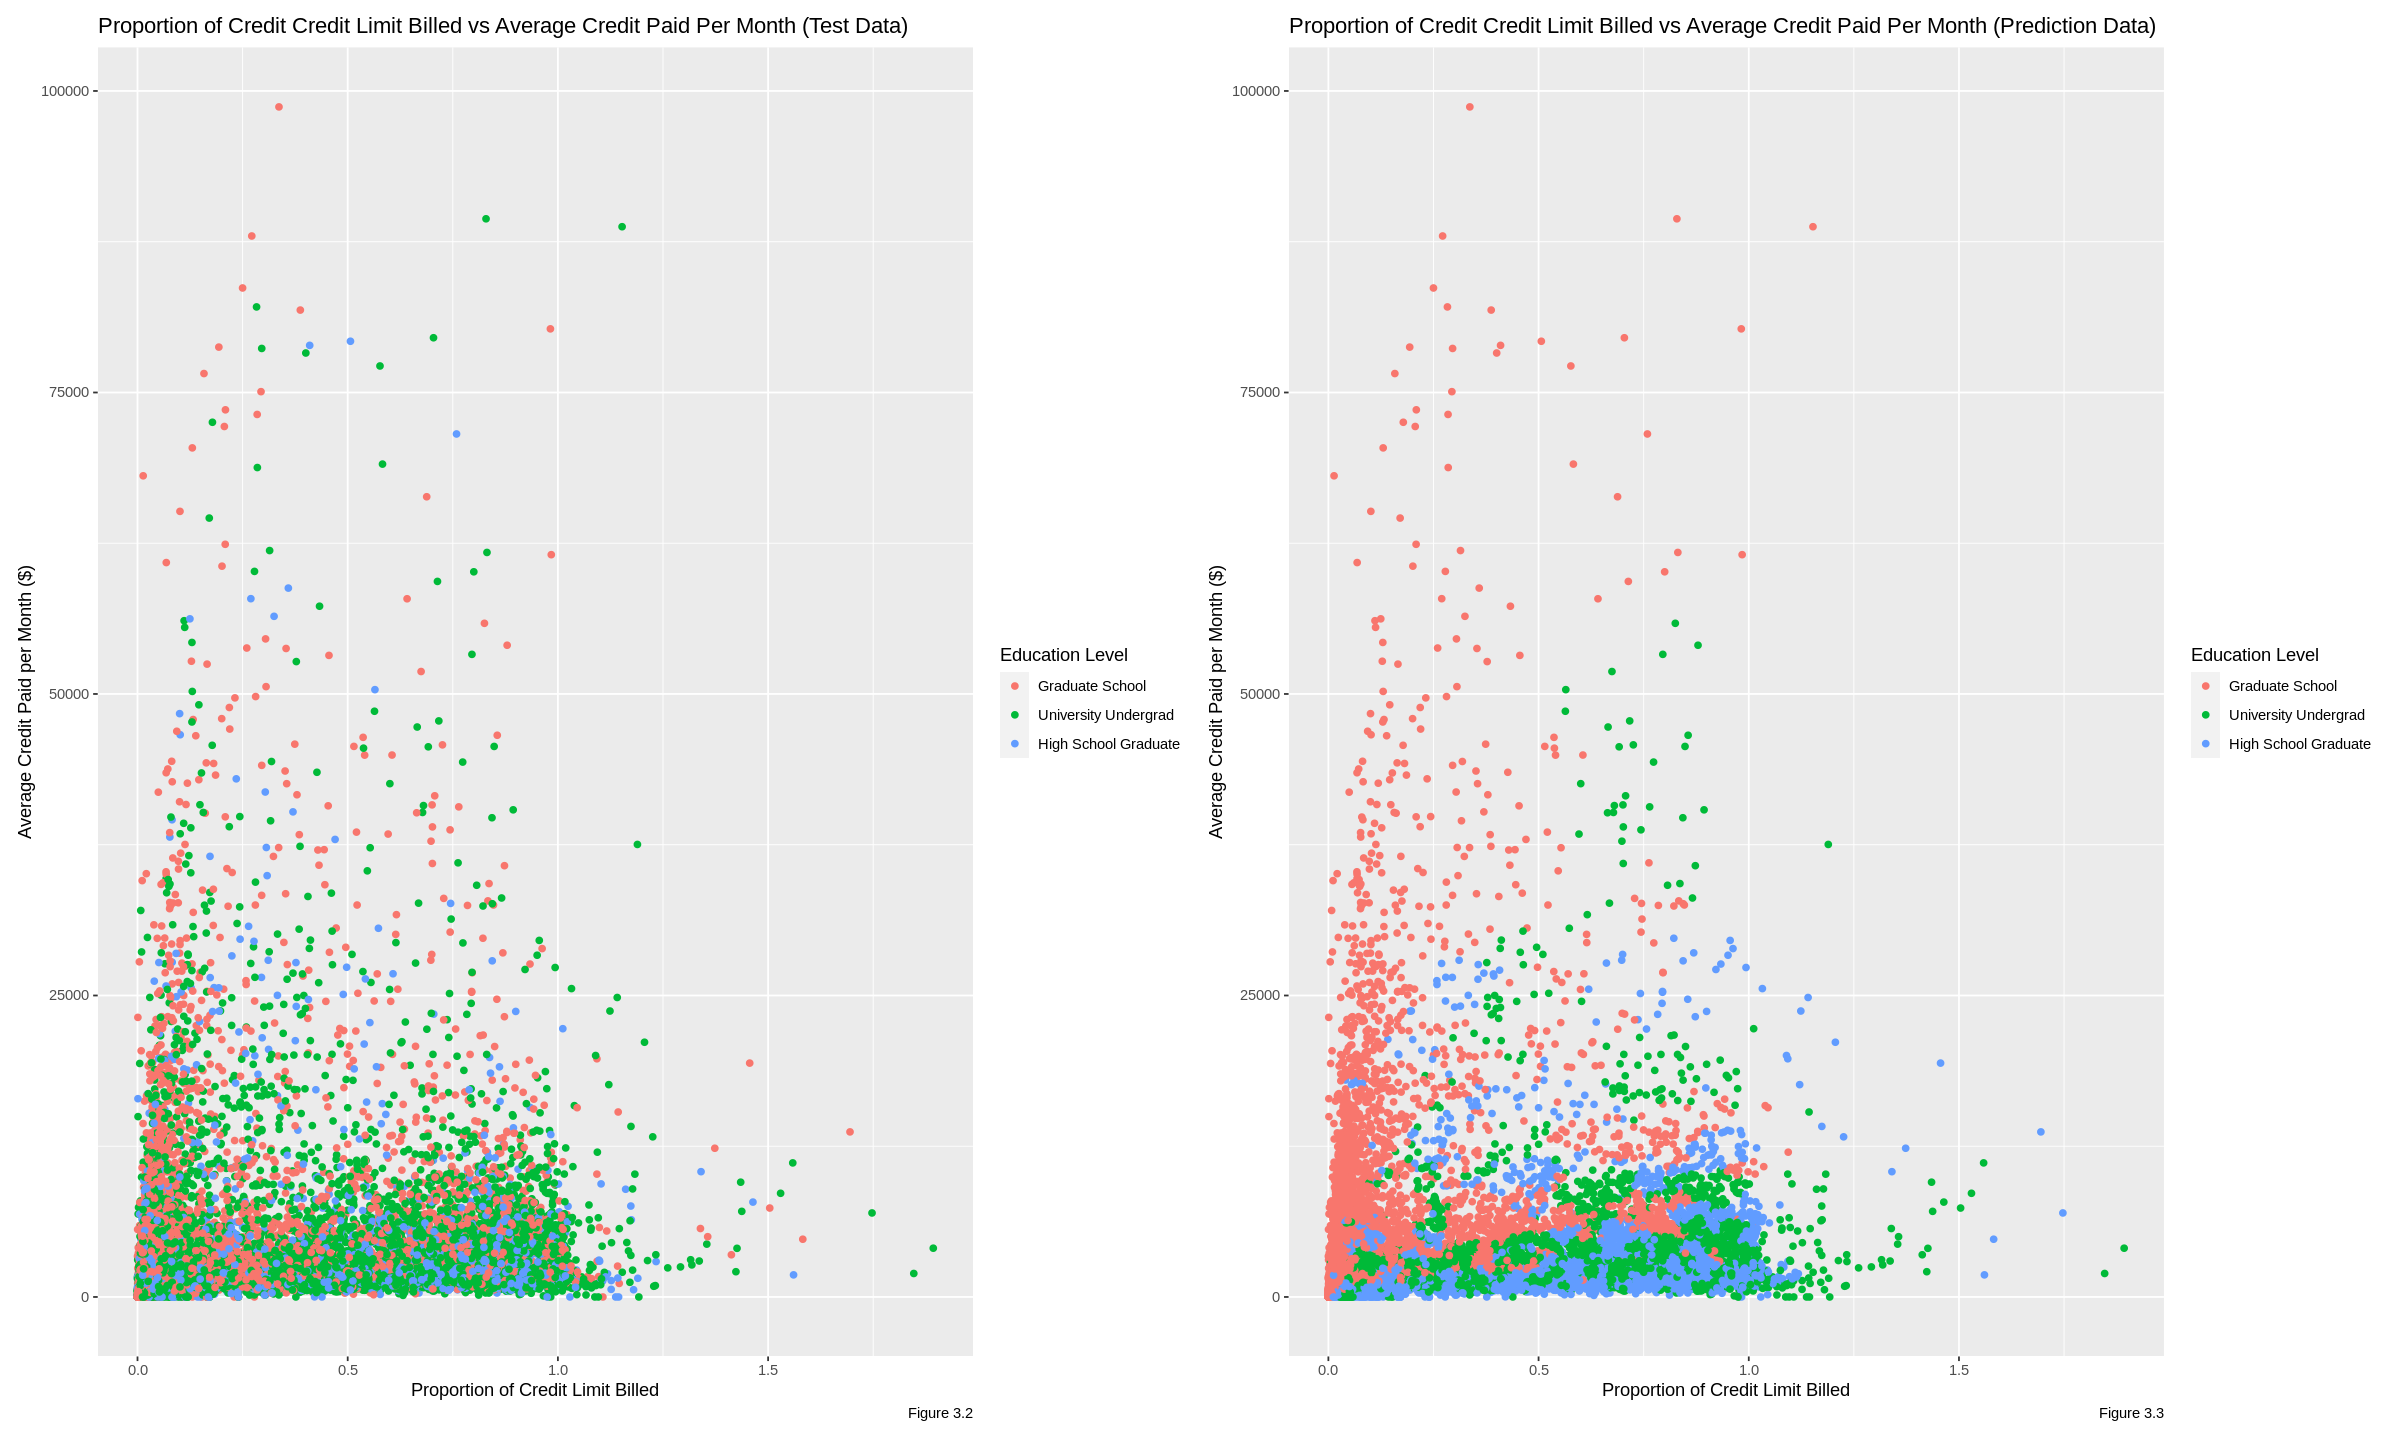

In [47]:
options(repr.plot.width = 20, repr.plot.height = 12)

test_plot <- credit_test %>%
    ggplot(aes(x=BILL_AVG,y=PAY_AVG,colour = EDUCATION)) +
    geom_point() +
    labs(x='Proportion of Credit Limit Billed',y='Average Credit Paid per Month ($)', caption = 'Figure 3.2', colour = "Education Level") +
    ggtitle('Proportion of Credit Credit Limit Billed vs Average Credit Paid Per Month (Test Data)') +
    scale_colour_discrete(labels = c("Graduate School","University Undergrad","High School Graduate"))

prediction_plot <- credit_test_predictions %>%
    ggplot(aes(x=BILL_AVG,y=PAY_AVG,colour = .pred_class)) +
    geom_point() +
    labs(x='Proportion of Credit Limit Billed',y='Average Credit Paid per Month ($)', caption = 'Figure 3.3',colour = "Education Level") +
    ggtitle('Proportion of Credit Credit Limit Billed vs Average Credit Paid Per Month (Prediction Data)') +
    scale_colour_discrete(labels = c("Graduate School","University Undergrad","High School Graduate"))

test_plot + prediction_plot

### Discussion:
**Summary**

Through our investigation, we found that it was not possible to predict an individual’s education based on the average amount of credit used by the individual (NT dollars) relative to their credit limit and the average amount paid (NT dollars), as our classification model only achieved an accuracy of 40.19%. We may have overplotted the data due to the large dataset utilized (30, 000 instances), making it difficult to see individual points. Based on the scatter plot, there seems to be a slight positive correlation between the proportion of credit credit limit billed versus average credit paid per month across all education levels, with many outliers in the graduate school category. Generally, it appears that individuals with education levels lower than graduate school have a higher chance of having a lower amount of average credit paid per month with a larger proportion of credit limit being billed, while individuals with graduate school education have a higher average amount of credit paid per month with a lower proportion of the credit limit being billed. 

**Expected Findings**

We expected to find that individuals who have a lower average amount of credit used relative to their credit limit and average amount paid back  will have higher education levels than those who have a higher average amount of credit used relative to their credit limit  and average amount paid back.  Unexpectedly,  we only achieved an accuracy of 40.19% with our classification model which means that the data cannot be used to label and predict education levels based on credit history. Based on our findings, we found that it  is not possible to measure an individual's education level based on credit history, as many other unrelated factors can impact education level. 

**Impact**

By verifying our prediction,  we hoped that we would disclose information on the relationship between socioeconomic statuses and education (in Taiwan), as well as highlight the advantages of pursuing higher education after high school and how it can help people maintain spending habits. We also hoped that the results from our findings could encourage the government to put more effort in promoting and supporting higher education for individuals of lower socioeconomic statuses, to help decrease wealth inequality. However, our findings only verify that it is not possible to predict an individual’s education level just based on credit history as there are other various factors that can impact these variables. 

**Further Explorations**

One could investigate how to improve the accuracy of our model. If that is not possible, perhaps there are other superior ways to relate credit history with education level, as shown in the articles mentioned in the introduction. Furthermore, another area to investigate is whether there are other variables in the UCI data set with a stronger correlation to credit history such as marital status or age. 

### Citations:
1. Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

2. CBC News (2016). Higher education still worth the money, new research suggests. Retrieved from https://www.cbc.ca/news/business/university-college-degree-salary-1.3695254

3. Indeed Editorial Team (2021). Average Salary With vs. Without a College Degree. Retrieved from https://www.indeed.com/career-advice/pay-salary/average-salary-with-college-degree-vs-without